In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

Building PCSE demo database at: /home/jeremy/.pcse/pcse.db ... OK


# Parameters

In [52]:
paramVariete = {
                # récupérés depuis HV42 parameters
                "TBase":10,
                "TOpt1":25,
                "TOpt2":35,
                "TLim":40,

                "VRacBVP":15.0,
                "VRacPSP":15.0,
                "VRacRPR":15.0,
                "VRacMatu1":8.0,
                "VRacMatu2":8.0,

                "SDJLevee":50,
                "SDJBVP":300, # 400
                "SDJRPR":300, # 400
                "SDJMatu1":300, # 400
                "SDJMatu2":50,

                "kcMax":1.2,
                "PFactor":0.5,
                "seuilCstrMortality":3,
                "PPSens":0.7,

                'txAssimMatu1':1,
                'txAssimMatu2':0.5,

                'txConversion':4, # 4 pour C4, 6 pour C4
                'kdf': 0.5, # Light extinction and conversion

                "tempMaint":25,
                "txResGrain":0.5,
                "poidsSecGrain":0.028,
                "aeroTotPente":1E-5,
                "aeroTotBase":0.6,

                "pcReallocFeuille":0.7,
                "feuilAeroBase":0.6,

                "KRdtPotA": 0.4,
                "KRdtPotB": 200,

                "txRealloc":0.5,
                "slaMax":0.0060,
                "slaMin":0.0018,
                

                # pas dans le fichier de params
                "VRacLevee":15.0, # pas dans les params
                'txAssimBVP':1,
                "txRespMaint":1, # ????
                "feuilAeroPente":1E-5, #???
                "KRdtBiom":10, #?????
                "slaPente":1,

                # à vérifier
                
                }

paramITK = {"humSatMc":0, # humidité des résidus de couverture ?
            "biomIniMc":0, # Biomasse des résidues de couverture (Mulch). Unités : kg/ha
            "profRacIni":1,
            "irrigAuto":True,
            "irrigAutoTarget":0.5,
            "maxIrrig":20,
            "precision":0.1,
            "surfMc":0.0,
            "seuilEauSemis":5.0,
            "mulch":10,
            "coefMc":1,
            "nbjTestSemis":3,
            "seuilCstrMortality":10,
            "dateFin":450,
            "densite":5000,
            }

paramTypeSol = {"ru":10,
                "epaisseurSurf":0.2,
                "stockIniSurf":5,
                "seuilRuiss":1, # qté d'eau à partir de laquelle on entre dans un régime de ruissellement (mm)
                "pourcRuiss":0.5, # pourcentge de pluie qui ruisselle passé le seuil seuilRuiss (pct décimal)
                "stockIniProf":0.5,
                "epaisseurProf" : 1,
                }

# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

# Initialization of variables

In [3]:
# getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=5, latitude=52)
print(weatherdata)
df = pd.DataFrame(weatherdata.export())
df = df[(df["DAY"]>=datetime.date(2020,1,1)) & (df["DAY"]<=datetime.date(2020,1,1)+datetime.timedelta(days=paramITK["dateFin"]))]
df.head()

df["DOY"] = df.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)

# initializing variables
grid_width = 1
grid_height = 1

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2022-07-03
Number of missing days: 1



In [171]:
stockSurfaceInit = 10

def init():
        
        data = {

        # phenologie - init
        "numPhase": np.zeros(shape=(grid_width, grid_height, len(df))), # Phases phénologiques
        "ruRac": np.full((grid_width, grid_height, len(df)), paramITK["profRacIni"] / 1000 * paramTypeSol["ru"]), # Capacité maximum d'eau rapporté à la profondeur racinaire en cours. Unité : mm
        "nbJourCompte": np.zeros(shape=(grid_width, grid_height, len(df))), # ??????????????????

        # phenologie - EvalDegresJourSarrahV3
        "ddj": np.zeros(shape=(grid_width, grid_height, len(df))),
        "sdj": np.zeros(shape=(grid_width, grid_height, len(df))), # Somme de degrés.jours depuis la germination. Unité : °C.d
        "tpMoy": df["TEMP"].values.reshape(grid_width, grid_height, len(df["TEMP"].values)), # = tempMoy

        # phenologie - EvalPhenoSarrahV3
        "stockSurface" : np.full((grid_width, grid_height, len(df)),stockSurfaceInit), # Stock d'eau initial dans l'horizon de surface. Unité : mm
        "ruSurf": np.full((grid_width, grid_height, len(df)),paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]), # Reserve utile de l'horizon de surface.  Unités :mm
        "changePhase" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "seuilTempPhaseSuivante": np.zeros(shape=(grid_width, grid_height, len(df))), # Seuil des tempÚratures cumulÚes pour la phase suivante. Unité : °C.d 
        "sommeDegresJourPhasePrec": np.zeros(shape=(grid_width, grid_height, len(df))), # Somme en degrÚs/jour de la phase précédente. Unité : °C.d
        "phasePhotoper": np.zeros(shape=(grid_width, grid_height, len(df))), # Egal a 1 pendant la phase de photopÚriode (0 sinon). 
        "dateRecolte": np.zeros(shape=(grid_width, grid_height, len(df))), # ??????????????????
        "nbjStress": np.zeros(shape=(grid_width, grid_height, len(df))), # ??????????????????

        # phenologie - PPTmoySarrahV3
        "jourFinPP": np.zeros(shape=(grid_width, grid_height, len(df))),
        "TMoyMatu": np.zeros(shape=(grid_width, grid_height, len(df))),
        "deltaBiomasseAerienne": np.zeros(shape=(grid_width, grid_height, len(df))),
        
        # phenologie - MortaliteSarraV3
        # n/a

        # bilan carbo
        # bilan carbo - EvalVitesseRacSarraV3
        "vRac" : np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - valConversion
        "KAssim" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "conv" : np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - EvalLtr
        "ltr": np.zeros(shape=(grid_width, grid_height, len(df))),
        "lai" : np.full((grid_width, grid_height, len(df)),0.1),
        "parIntercepte" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "rgcalc" : np.full((grid_width, grid_height, len(df)), df["IRRAD"]),
        "assimPot" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "assim" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "trPot" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "tr" : np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - EvalRespMaintSarrahV3
        "dRespMaint" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "biomasseTotale" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "tMoy" : np.zeros(shape=(grid_width, grid_height, len(df))), # différent de tpMoy ???
        "biomasseFeuilles" : np.zeros(shape=(grid_width, grid_height, len(df))),
        "deltaBiomasseTotale": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - repartitionAerienRacinaire
        "biomasseAerienne": np.zeros(shape=(grid_width, grid_height, len(df))),
        "biomasseRacinaire": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - repartition feuille tige
        "dayBiomLeaf": np.zeros(shape=(grid_width, grid_height, len(df))),
        "reallocation": np.zeros(shape=(grid_width, grid_height, len(df))),
        "biomasseTiges": np.zeros(shape=(grid_width, grid_height, len(df))),
        "rdt": np.zeros(shape=(grid_width, grid_height, len(df))),
        "biomasseVegetative": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - EvalRdtPotRespSarrahV3
        "biomTotStadeIP": np.zeros(shape=(grid_width, grid_height, len(df))),
        "biomasseTotaleStadeF": np.zeros(shape=(grid_width, grid_height, len(df))),
        "rdtPot": np.zeros(shape=(grid_width, grid_height, len(df))),
        "drespmaint": np.zeros(shape=(grid_width, grid_height, len(df))),
        "dRdtPot": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - EvalReallocationSarrahV3
        "manqueAssim": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan carbo - EvalSlaSarrahV3_EvolLAIPhases
        "sla": np.zeros(shape=(grid_width, grid_height, len(df))),




        # bilan hydro
        # bilan hydro - EvalIrrigPhase
        "stockRac": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockIrr": np.zeros(shape=(grid_width, grid_height, len(df))),
        "ruIrr": np.zeros(shape=(grid_width, grid_height, len(df))),
        "correctedIrrigation": np.zeros(shape=(grid_width, grid_height, len(df))),
        "irrigTotDay": np.zeros(shape=(grid_width, grid_height, len(df))),
        "rain": df["RAIN"].values.reshape(grid_width, grid_height, len(df["RAIN"].values)),
        "eauDispo": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan hydro - rempliMc_evalRunOff
        "biomMc": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockMc": np.zeros(shape=(grid_width, grid_height, len(df))),
        "eauCaptee": np.zeros(shape=(grid_width, grid_height, len(df))),
        "lr": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan hydro - EvolRurCstr
        "cstr": np.zeros(shape=(grid_width, grid_height, len(df))),
        "ru": np.zeros(shape=(grid_width, grid_height, len(df))),
        "dayVrac": np.zeros(shape=(grid_width, grid_height, len(df))),
        "hum": np.zeros(shape=(grid_width, grid_height, len(df))),
        "deltaRur": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan hydro - rempliRes
        "profRu": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stRuMax": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stRuSurfPrec": np.zeros(shape=(grid_width, grid_height, len(df))),
        "eauTranspi": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockTotal": np.zeros(shape=(grid_width, grid_height, len(df))),
        "dr": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan hydro - Evaporation
        "stockSurfaceTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "feswTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "ltrTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "kceTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "etp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "evalPotTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "stockMcTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "FEMcW": np.zeros(shape=(grid_width, grid_height, len(df))),
        "evapTemp": np.zeros(shape=(grid_width, grid_height, len(df))),

        # bilan hydro - transpiration
        "ftsw": np.zeros(shape=(grid_width, grid_height, len(df))),
        "kcp": np.zeros(shape=(grid_width, grid_height, len(df))),
        "pFact": np.zeros(shape=(grid_width, grid_height, len(df))),

        #bilan hydro - consoResSep
        "evap": np.zeros(shape=(grid_width, grid_height, len(df))),
        "trSurf": np.zeros(shape=(grid_width, grid_height, len(df))),
        "consoRur": np.zeros(shape=(grid_width, grid_height, len(df))),


        #  # pluviométrie (mm)
        # "biomMc": np.full((grid_width, grid_height, len(df)),paramITK["biomIniMc"]), # Biomasse des résidues de couverture (Mulch). Unités : kg/ha
        # 
        # "irrig" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "hum" : np.zeros(shape=(grid_width, grid_height, len(df))), # Quantité d'eau maximum jusqu'au front d'humectation. Unités : mm
        # 
        
        # "stockRac" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "correctedIrrigation" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "irrigTotDay" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "ruIrr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "stockIrr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "eauDispo" : np.zeros(shape=(grid_width, grid_height, len(df))), # Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
        # "stockMc" : np.zeros(shape=(grid_width, grid_height, len(df))), # Stock d'eau dans les résidus (mulch). Unités : mm
        # "lr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "eauCaptee" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "cstr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "ru" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "dayVrac" : np.zeros(shape=(grid_width, grid_height, len(df))),	
        # "deltaRur" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "profRu" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "stRuMax" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "stRuSurfPrec" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "eauTranspi" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "stockTotal" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "dr" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "stockSurfaceTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "feswTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "ltrTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "bioMc" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "kceTemp" : np.zeros(shape=(grid_width, grid_height, len(df))),
        # "etp": np.full((grid_width, grid_height, len(df)),df["ET0"].values),
        # "evalPotTemp": np.full((grid_width, grid_height, len(df)),df["ET0"].values),
        # "stockMcTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "FEMcW": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "evapTemp": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "ftsw": np.zeros(shape=(grid_width, grid_height, len(df))),
        # 
        # "kcp": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "trPot": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "pFact": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "tr": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "evap": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "trSurf": np.zeros(shape=(grid_width, grid_height, len(df))),
        # "consoRur": np.zeros(shape=(grid_width, grid_height, len(df))),
        
        
        # "seuilTempPhasePrec": np.zeros(shape=(grid_width, grid_height, len(df))),
        
        
        
        # "dateFin": np.zeros(shape=(grid_width, grid_height, len(df))),
        # 
        # 
        #
        # "profRu": np.full((grid_width, grid_height, len(df)),paramTypeSol["epaisseurSurf"] + paramTypeSol["epaisseurProf"])
        

        }
        return data

In [5]:
def initialisationSol(data, paramTypeSol):
	"""
 		//remplacé par 
 	   	let  truSurf= paramTypeSol.epaisseurSurf / 1000 * paramTypeSol.ru
 	   	ruSurf = truSurf
		ru = paramTypeSol.ru
		let rRac= paramTypeSol.ru * paramITK.profRacIni / 1000
		ruRac = rRac
		//fin remplacé par 
	    //ruSurf= paramTypeSol.EpaisseurSurf",solNames,  typesSol) / 1000 * paramTypeSol.Ru",solNames,  typesSol)
		//modif 10/06/2015  plus de pft
	    //let pfT = paramTypeSol.EpaisseurSurf",solNames,  typesSol) * paramTypeSol.HumPF",solNames,  typesSol)
	    //pfTranspi = pfT
	    //let sT = paramTypeSol.StockIniSurf",solNames,  typesSol) - pfT/2 + paramTypeSol.StockIniProf",solNames,  typesSol)
	    let sT = paramTypeSol.stockIniSurf + paramTypeSol.stockIniProf
	    stockTotal = sT
	    profRu = paramTypeSol.epaisseurSurf  + paramTypeSol.epaisseurProf
		//modif 10/06/2015 hum mis a au moins ruSurf
		let tHum =  Max(truSurf,rRac)	 
		hum = Max (sT, tHum)
		}
	} // fin initialisationSol 
	"""
	# ruSurf (truSurf) : Reserve utile de l'horizon de surface. Unités :mm
	# data["ruSurf"] =  paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

	# ruRac (rRac) : Capacité maximum d'eau rapporté à la profondeur racinaire en cours. Unité : mm
	# data["ruRac"] =  np.full((grid_width, grid_height, len(df)), paramITK["profRacIni"] / 1000 * paramTypeSol["ru"])

	# stockTotal (sT) : Stock d'eau total sur l'ensemble des réservoir. Unités : mm
	data["stockTotal"] = paramTypeSol["stockIniSurf"] + paramTypeSol["stockIniProf"] 

	# Profondeur maximale de sol. Unités : mm
	# data["profRu"] = paramTypeSol["epaisseurSurf"] + paramTypeSol["epaisseurProf"]

	# valeur maximale entre la réserve utile du réservoir de surface et la réserve utile racinaire (mm)
	data["tHum"] = np.maximum(data["ruSurf"], data["ruRac"])

	# Quantité d'eau maximum jusqu'au front d'humectation. Unités : mm
	data["hum"] = np.maximum(data["stockTotal"], data["tHum"])

	return data

# Bilan phéno

## Fonctions

In [6]:
def EvalDegresJourSarrahV3(j, data, paramVariete):
    
    # calcul des degrés jour
    data["ddj"][:,:,j] = np.where(
        data["tpMoy"][:,:,j] <= paramVariete["TOpt2"],
        np.maximum(np.minimum(paramVariete["TOpt1"], data["tpMoy"][:,:,j]), paramVariete["TBase"]) - paramVariete["TBase"],
        (paramVariete["TOpt1"] - paramVariete["TBase"]) * (1 - ((np.minimum(paramVariete["TLim"], data["tpMoy"][:,:,j]) - paramVariete["TOpt2"])
            / (paramVariete["TLim"] - paramVariete["TOpt2"]))),
    )  

    # calcul de la somme de degré jour
    data["sdj"][:,:,j] = np.where(
        data["numPhase"][:,:,j] >= 1,
        data["sdj"][:,:,j-1] + data["ddj"][:,:,j],
        0,
    )

    return data


In [7]:
def EvalPhenoSarrahV3(j, data, paramITK):
    """	    
    EvolPhenoSarrahV3
	7 phases déterminent les processus de développement de la plante. 
	Elles sont déterminées en fonction d'un seuil de somme de degrés jours uiltempphasesuivante) et,pour la phase 3, de la photopériode.
	ChangePhase=1 si la phase a changé le jour même, sinon 0.
	modification 28/07/2015 retire rusurf/10 dans test semis	
    """

    ### détermination des dates de changement de phase

    # test phase 0 - germination
    condition = (data["numPhase"][:,:,j]==0) & (data["stockSurface"][:,:,j] - data["ruSurf"][:,:,j] / 10 >= paramITK["seuilEauSemis"])
    data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])
    data["seuilTempPhaseSuivante"][:,:,j:] = np.where(condition, paramVariete["SDJLevee"], data["seuilTempPhaseSuivante"][:,:,j])

    # test phase 1 (identique test phase 4 et +)
    condition = (data["numPhase"][:,:,j]==1) & (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])
    data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

    # test phase 2
    condition = (data["numPhase"][:,:,j]==2) & (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])
    data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

    # test phase 3
    condition = (data["numPhase"][:,:,j]==3) & (data["phasePhotoper"][:,:,j] == 0)
    data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

    # test phase 4 et +
    condition = (data["numPhase"][:,:,j]>=4) & (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])
    data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])



    ### la phase a changé, on met à jour les seuils de test de changement de phase
    
    data["sommeDegresJourPhasePrec"][:,:,j:] = np.where(
        data["changePhase"][:,:,j] == 1,
        data["seuilTempPhaseSuivante"][:,:,j],
        data["sommeDegresJourPhasePrec"][:,:,j],
    )

    data["numPhase"][:,:,j:] = np.where(
        data["changePhase"][:,:,j] == 1,
        data["numPhase"][:,:,j] + 1 ,
        data["numPhase"][:,:,j],
    )

    # phase 1
    data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==1),
        paramVariete["SDJLevee"],
        data["seuilTempPhaseSuivante"][:,:,j]
    )

    # phase 2
    data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==2),
        data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJBVP"],
        data["seuilTempPhaseSuivante"][:,:,j]
    )  

    # phase 4
    data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==4),
        data["sdj"][:,:,j] + paramVariete["SDJRPR"],
        data["seuilTempPhaseSuivante"][:,:,j]
    ) 

    # phase 5
    data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==5),
        data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu1"],
        data["seuilTempPhaseSuivante"][:,:,j]
    )

    # phase 6
    data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==6),
        data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu2"],
        data["seuilTempPhaseSuivante"][:,:,j]
    )                                                    



    data["phasePhotoper"][:,:,j] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==3),
        1,
        data["phasePhotoper"][:,:,j],
    )           

    data["nbjStress"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==7),
        paramVariete["seuilCstrMortality"] + 1,
        data["nbjStress"][:,:,j],
    )

    data["dateRecolte"][:,:,j] = np.where(
        (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==7),
        j,
        data["dateRecolte"][:,:,j],
    )
    
    return data                            

In [8]:
def PPTmoySarrahV3(j, data, paramVariete):
    """
	PPTmoySarrahV3
	Remplace photopériode: à partir de la fin de la saison des pluies on estime la durée de photopériode
	on déduit de la date de fin de saison la date de fin de la phase photoper fn (Somme degrés Jours phases Matu + RPR, TmoyMatu), 
	on estime donc des variétés virtuelles
    """

    # on calcule le jour de la fin de la photopériode
    data["jourFinPP"][:,:,j:] = np.where(
        data["phasePhotoper"][:,:,j] == 1,
        paramITK["dateFin"] - ((paramVariete["SDJMatu1"] + paramVariete["SDJMatu2"] + paramVariete["SDJRPR"]) / (data["TMoyMatu"][:,:,j] - paramVariete["TBase"])),
        data["jourFinPP"][:,:,j],
    )

    # on corrige les dates inférieures à 0 en rajoutant 365 j
    data["jourFinPP"][:,:,j] = np.where(
        (data["phasePhotoper"][:,:,j] == 1) & (data["jourFinPP"][:,:,j]<0),
        365 + data["jourFinPP"][:,:,j],
        data["jourFinPP"][:,:,j],
    )

    data["phasePhotoper"][:,:,j] = np.where(
                                    (data["phasePhotoper"][:,:,j] == 1),
                                    np.where(
                                        j > data["jourFinPP"][:,:,j],
                                        0,
                                        data["phasePhotoper"][:,:,j],
                                    ) if paramVariete["PPSens"] <= 1 else 0,
                                    data["phasePhotoper"][:,:,j],
                                    )

    data["changePhase"][:,:,j] = np.where(
                                    (data["phasePhotoper"][:,:,j] == 1),
                                    np.where(
                                        j > data["jourFinPP"][:,:,j],
                                        1,
                                        data["changePhase"][:,:,j],
                                    ) if paramVariete["PPSens"] <= 1 else 0,
                                    data["changePhase"][:,:,j],
                                    )

    return data

In [9]:
def MortaliteSarraV3(j, data, paramITK):

    # test de mortalité juvénile

    data['nbJourCompte'][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 2,
        data['nbJourCompte'][:,:,j] + 1,
        data['nbJourCompte'][:,:,j],
    )

    data["nbjStress"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbJourCompte"][:,:,j] < paramITK["nbjTestSemis"]) & (data["deltaBiomasseAerienne"][:,:,j] < 0),
        data["nbjStress"][:,:,j] + 1,
        data["nbjStress"][:,:,j],                           
    )

    data["nbJourCompte"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
        0,
        data["nbJourCompte"][:,:,j],
    )

    data["numPhase"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
        0,
        data["numPhase"][:,:,j],
    )

    data["ruRac"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
        0,
        data["ruRac"][:,:,j],
    )

    data["nbjStress"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] < paramITK["seuilCstrMortality"]),
        0,
        data["nbjStress"][:,:,j],
    )

    return data
                                    


## Bilan

In [10]:
def bilanPheno(j, data, paramITK, paramTypeSol, paramVariete):
	
    
    data['numPhase'][:,:,j:] = np.where(
                                    data['numPhase'][:,:,j]==7,
                                    0,
                                    data['numPhase'][:,:,j],
                                    )

    data['ruRac'][:,:,j:] = np.where(
                                    data['numPhase'][:,:,j]==7,
                                    0,
                                    data['ruRac'][:,:,j],
                                    )

    data['nbJourCompte'][:,:,j:] = np.where(
                                    data['numPhase'][:,:,j]==7,
                                    0,
                                    data['nbJourCompte'][:,:,j],
                                    )
    
    
    # if (j >= (dateDebut + varDateSemis) && nbjStress < paramVariete.seuilCstrMortality ){
	

    data = EvalDegresJourSarrahV3(j, data, paramVariete)
    data = EvalPhenoSarrahV3(j, data, paramITK)
    data = PPTmoySarrahV3(j, data, paramVariete)
    data = MortaliteSarraV3(j, data, paramITK)

    # bilan carbo

    # else 

    # bilan hydro

    return data


# bilan carbo

In [18]:
def EvalVitesseRacSarraV3(j, data, paramVariete):
    # EvalVitesseRacSarraV3

    # phase 1
    data["vRac"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 1,
        paramVariete['VRacLevee'],
        data["vRac"][:,:,j],
    )

    # phase 2
    data["vRac"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 2,
        paramVariete['VRacBVP'],
        data["vRac"][:,:,j],
    )

    # phase 3
    data["vRac"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 3,
        paramVariete['VRacPSP'],
        data["vRac"][:,:,j],
    )

    # phase 4
    data["vRac"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 4,
        paramVariete['VRacRPR'],
        data["vRac"][:,:,j],
    )

    # phase 5
    data["vRac"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 5,
        paramVariete['VRacMatu1'],
        data["vRac"][:,:,j],
    )
    
    # phase 6
    data["vRac"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 6,
        paramVariete['VRacMatu2'],
        data["vRac"][:,:,j],
    )

    return data

In [19]:
def EvalConversion(j, data, paramVariete):
    # EvalConversion
    data["KAssim"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 2,
        1,
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 3,
        paramVariete['txAssimBVP'],
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 4,
        paramVariete['txAssimBVP'],
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 5,
        paramVariete["txAssimBVP"] + (data['sdj'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]) * (paramVariete['txAssimMatu1'] -  paramVariete['txAssimBVP']) / (data['seuilTempPhaseSuivante'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]),
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j] = np.where(
        data["numPhase"][:,:,j] == 6,
        paramVariete["txAssimMatu1"] + (data["sdj"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]) * (paramVariete["txAssimMatu2"] - paramVariete["txAssimMatu1"]) / (data["seuilTempPhaseSuivante"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]),
        data["KAssim"][:,:,j],
    )

    data["conv"][:,:,j] = data["KAssim"][:,:,j] * paramVariete["txConversion"]

    return data

In [20]:
def EvalLtr(data, paramVariete):
    # EvalLtr + EvalParIntercetpe+ EvalAssimPot+ EvalAssimSarrahV3
    # estimation de l'assimilation en fonction du rayonnement, réduite par le stress hydrique
    data["ltr"][:,:,j] = np.exp(-paramVariete["kdf"] * data["lai"][:,:,j])

    # KPar remplacé par 0.5 attention ajouter Rg 
    data["parIntercepte"][:,:,j] = 0.5 * (1 - data["ltr"][:,:,j]) * data["rgcalc"][:,:,j]
    data["assimPot"][:,:,j] = data["parIntercepte"][:,:,j] * data["conv"][:,:,j] * 10

    data["assim"][:,:,j] = np.where(
        data["trPot"][:,:,j] > 0,
        data["assimPot"][:,:,j] * data["tr"][:,:,j] / data["trPot"][:,:,j],
        0,
    )

    return data

In [21]:
def EvalRespMaintSarrahV3(j, data, paramVariete, paramITK):

    data["dRespMaint"][:,:,j] =  ((paramVariete["txRespMaint"] * data["biomasseTotale"][:,:,j] * ((data["tMoy"][:,:,j] - paramVariete["tempMaint"]) / 10)**2)) + (paramVariete["txRespMaint"] * data["biomasseFeuilles"][:,:,j] * ((data["tMoy"][:,:,j] -  paramVariete["tempMaint"]) / 10)**2)

    # Question pourquoi > 4 tous le s !!! si pas de feuilles mort !!! 	
    data["dRespMaint"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] > 4) & (data["biomasseFeuilles"][:,:,j]==0),
        0,
        data["dRespMaint"][:,:,j],
    )

    data["biomasseTotale"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]==2) & (data["changePhase"][:,:,j]==1),
        paramITK["densite"] *  paramVariete["txResGrain"] *  paramVariete["poidsSecGrain"] / 1000,
        data["biomasseTotale"][:,:,j]  + (data["assim"][:,:,j] - data["dRespMaint"][:,:,j]),
    )

    data["deltaBiomasseTotale"][:,:,j] = (data["assim"][:,:,j] - data["dRespMaint"][:,:,j])

    return data

In [22]:
def repartitionAerienRacinaire(j, data, paramVariete):
    
    data["deltaBiomasseAerienne"][:,:,j] = data["biomasseAerienne"][:,:,j]

    data["biomasseAerienne"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>=2) & (data["numPhase"][:,:,j]<=4),
        np.minimum(0.9, paramVariete["aeroTotPente"] * data["biomasseTotale"][:,:,j] + paramVariete["aeroTotBase"]) * data["biomasseTotale"][:,:,j],
        data["biomasseTotale"][:,:,j] - data["biomasseAerienne"][:,:,j],
    )

    data["deltaBiomasseAerienne"][:,:,j] = data["biomasseAerienne"][:,:,j] - data["deltaBiomasseAerienne"][:,:,j]
    data["biomasseRacinaire"][:,:,j] = data["biomasseTotale"][:,:,j] - data["biomasseAerienne"][:,:,j]

    return data

In [23]:
def repartitionFeuilleTige(j, data, paramVariete):

    data["dayBiomLeaf"][:,:,j]=np.where(
        data["numPhase"][:,:,j]>1,
        data["biomasseFeuilles"][:,:,j],
        data["dayBiomLeaf"][:,:,j],
    )

    data["biomasseFeuilles"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]<0),
        np.maximum(0.0, data["biomasseFeuilles"][:,:,j] - (-data["deltaBiomasseAerienne"][:,:,j] + data["reallocation"][:,:,j])	* paramVariete["pcReallocFeuille"]),
        data["biomasseFeuilles"][:,:,j],
    )

    data["biomasseTiges"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]<0),
        np.maximum(0.0, data["biomasseTiges"][:,:,j] - (-data["deltaBiomasseAerienne"][:,:,j] + data["reallocation"][:,:,j])	* paramVariete["pcReallocFeuille"]), #! attention on utilise ici le pcReallocFeuille ?
        data["biomasseTiges"][:,:,j],
    )



    bM = paramVariete["feuilAeroBase"] - 0.1
    cM = (( paramVariete["feuilAeroPente"] * 1000)/ bM + 0.78) / 0.75

    # numphase inférieur ou égal à 4

    data["biomasseFeuilles"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]>=0) & (data["numPhase"][:,:,j]<=4),
        (0.1 + bM * cM**(data["biomasseAerienne"][:,:,j] / 1000)) * data["biomasseAerienne"][:,:,j],
        data["biomasseFeuilles"][:,:,j],
    )

    data["biomasseTiges"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]>=0) & (data["numPhase"][:,:,j]<=4),
        data["biomasseAerienne"][:,:,j] - data["biomasseFeuilles"][:,:,j],
        data["biomasseFeuilles"][:,:,j],
    )


    # condition else : numphase supérieur à 4
    data["biomasseFeuilles"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]>=0) & (data["numPhase"][:,:,j]>4),
        data["biomasseFeuilles"][:,:,j] - data["reallocation"][:,:,j] *  paramVariete["pcReallocFeuille"],
        data["biomasseFeuilles"][:,:,j],
    )

    data["biomasseTiges"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]>=0) & (data["numPhase"][:,:,j]>4),
        data["biomasseTiges"][:,:,j] - (data["reallocation"][:,:,j] * (1-  paramVariete["pcReallocFeuille"])),
        data["biomasseTiges"][:,:,j],
    )

    data["biomasseAerienne"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1) & (data["deltaBiomasseAerienne"][:,:,j]>=0) & (data["numPhase"][:,:,j]>4),
        data["biomasseTiges"][:,:,j] + data["biomasseFeuilles"][:,:,j] + data["rdt"][:,:,j],
        data["biomasseAerienne"][:,:,j],
    )


    # else if ?
    data["dayBiomLeaf"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>1),
        data["biomasseFeuilles"][:,:,j] - data["dayBiomLeaf"][:,:,j],
        data["dayBiomLeaf"][:,:,j], 
    )

    data["biomasseVegetative"][:,:,j] = data["biomasseTiges"][:,:,j]   + data["biomasseFeuilles"][:,:,j]

    return data

In [24]:
def EvalRdtPotRespSarrahV3(j, data, paramVariete):
    data["biomTotStadeIP"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]==4) & (data["changePhase"][:,:,j]==1),
        data["biomasseTotale"][:,:,j],
        data["biomTotStadeIP"][:,:,j], 
    )

    data["biomasseTotaleStadeF"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]==5) & (data["changePhase"][:,:,j]==1),
        data["biomasseTotale"][:,:,j],
        data["biomasseTotaleStadeF"][:,:,j],
    )

    data["rdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]==5) & (data["changePhase"][:,:,j]==1),
        (paramVariete["KRdtPotA"] * (data['biomasseTotaleStadeF'][:,:,j] - data['biomTotStadeIP'][:,:,j]) +  paramVariete['KRdtPotB']) + paramVariete['KRdtBiom'] * data['biomasseTotaleStadeF'][:,:,j],
        data["rdtPot"][:,:,j],
    )

    data["rdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]==5) & (data["changePhase"][:,:,j]==1) & (data["rdtPot"][:,:,j]>data["biomasseTotale"][:,:,j]),
        data["biomasseTotale"][:,:,j],
        data["rdtPot"][:,:,j],
    )

    data["dRdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]==5) & (data["trPot"][:,:,j]>0),
        np.maximum((data["rdtPot"][:,:,j] * (data["ddj"][:,:,j] /  paramVariete["SDJMatu1"]) * (data["tr"][:,:,j] / data["trPot"][:,:,j])), (data["drespmaint"][:,:,j] * 0.15)),
        0,
    )

    return data

In [25]:
def EvalReallocationSarrahV3(j, data, paramVariete):
    data["manqueAssim"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5),
        np.maximum(0, (data["dRdtPot"][:,:,j] -  np.maximum(0.0, data["deltaBiomasseAerienne"][:,:,j]))),
        0,
    )

    data["reallocation"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5),
        np.minimum(data["manqueAssim"][:,:,j] *  paramVariete["txRealloc"],  np.maximum(0.0, data["biomasseFeuilles"][:,:,j] - 30)),
        0,
    )

    return data

In [41]:
def EvolDayRdtSarraV3(j, data):

    data["rdt"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5),
        data["rdt"][:,:,j] + np.minimum(data["dRdtPot"][:,:,j],  np.maximum(0.0, data["deltaBiomasseAerienne"][:,:,j]) + data['reallocation'][:,:,j]),
        data["rdt"][:,:,j],
    )

    return data

In [59]:
def EvalSlaSarrahV3_EvolLAIPhases(j, data, paramVariete):

    data["sla"][:,:,j] = np.where(
        (data["biomasseFeuilles"][:,:,j]>0) & (data["numPhase"][:,:,j]==1) & (data["changePhase"][:,:,j]==1),
        paramVariete["slaMax"],
        data["sla"][:,:,j],
    )

    data["sla"][:,:,j] = np.where(
        (data["biomasseFeuilles"][:,:,j]>0),
        np.minimum(paramVariete["slaMax"], np.maximum(paramVariete["slaMin"], (data["sla"][:,:,j] -  paramVariete["slaPente"] * (data["sla"][:,:,j] -  paramVariete["slaMin"])) * (data["biomasseFeuilles"][:,:,j] - data["dayBiomLeaf"][:,:,j]) / (data["biomasseFeuilles"][:,:,j] + (paramVariete["slaMax"] + data["sla"][:,:,j])/2 * (data["dayBiomLeaf"][:,:,j] / data["biomasseFeuilles"][:,:,j])))),
        data["sla"][:,:,j],
    )

    data["lai"][:,:,j] = np.where(
        data["numPhase"][:,:,j]<=1,
        0,
        np.where(
            data["numPhase"][:,:,j]<=6,
            data["biomasseFeuilles"][:,:,j] * data["sla"][:,:,j],
            0,
        )
    )

    return data

In [60]:
def bilanCarbo(j, data, paramITK, paramTypeSol, paramVariete):
    data = EvalVitesseRacSarraV3(j, data, paramVariete)
    data = EvalConversion(j, data, paramVariete)
    data = EvalLtr(data, paramVariete)
    data = EvalRespMaintSarrahV3(j, data, paramVariete, paramITK)
    data = repartitionAerienRacinaire(j, data, paramVariete)
    data = repartitionFeuilleTige(j, data, paramVariete)
    data = EvalRdtPotRespSarrahV3(j, data, paramVariete)
    data = EvalReallocationSarrahV3(j, data, paramVariete)
    data = EvolDayRdtSarraV3(j,data)
    data = EvalSlaSarrahV3_EvolLAIPhases(j, data, paramVariete)
    
    return data

# Bilan hydro

In [63]:
def EvalIrrigPhase(j, data, paramITK):
    # eauDispo : Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
    
    if paramITK["irrigAuto"]==True : # && (numphase > 0) && (numphase < 6) )
        data["stockIrr"][:,:,j] = np.where((data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
            data["stockSurface"][:,:,j],
            data["stockRac"][:,:,j],
        )
        data["ruIrr"][:,:,j] = np.where((data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
            data["ruSurf"][:,:,j],
            data["ruRac"][:,:,j],
        )
        
        data["irrigTotDay"][:,:,j] = np.where((data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"]),
            np.minimum(np.maximum(0, (data["ruIrr"][:,:,j] - data["stockIrr"][:,:,j]) * 0.9 - data["correctedIrrigation"][:,:,j]), paramITK["maxIrrig"]),
            data["irrigTotDay"][:,:,j],
        )
        # irrigTotDay = round(irrigTotDay /  paramITK.precision) *  paramITK.precision
    data["irrigTotDay"][:,:,j] = data["correctedIrrigation"][:,:,j] + data["irrigTotDay"][:,:,j]		
    
    data["eauDispo"][:,:,j] = data["rain"][:,:,j] + data["irrigTotDay"][:,:,j]
    
    return data

In [84]:

def rempliMc_evalRunOff(j, data, paramITK, paramTypeSol):

    # rempliMc
    # humSatMc ???
    # biomMc : biomasse mulch, kg/ha
    # stockMc : Stock d'eau dans les résidus (mulch). Unités : mm
    # eauDispo : Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
    # surfMc : ???
    
    # on calcule la quantité maximale d'eau stockable par le mulch en prenant le minimum entre :
    # - l'utilisation d'une fonction de la quantité d'eau disponible qui tend vers eauDispo quand surfMc ou biomMc augmentent
    # - la différence entre la quantité d'eau au point de saturation et le stock d'eau connu du mulch
    # on calcule ensuite l'eau disponible en retranchant l'eau captée si sa valeur est supérieure à 0
    # on incrémente ensuite la quantité d'eau dans le mulch par la quantité d'eau captée
    data["eauCaptee"][:,:,j] = np.minimum(
                                    data["eauDispo"][:,:,j] * (1-np.exp(-paramITK["surfMc"] * data["biomMc"][:,:,j]/1000)),
                                    (paramITK["humSatMc"] * data["biomMc"][:,:,j]/ 10000) - data["stockMc"][:,:,j],
                                    )
    data["eauDispo"][:,:,j] =  np.maximum(data["eauDispo"][:,:,j] - data["eauCaptee"][:,:,j], 0)
    data["stockMc"][:,:,j] = data["stockMc"][:,:,j] + data["eauCaptee"][:,:,j]
    
    # EvalRunOff
    # rain : pluviométrie (mm)
    # seuilRuiss : Seuil pluie, calcul du ruissellement (cf PourcRuiss) (mm)
    # pourcRuiss : (pct décimal)
    data["lr"][:,:,j] = np.where(data["rain"][:,:,j] > paramTypeSol["seuilRuiss"],
                            (data["eauDispo"][:,:,j]  - paramTypeSol["seuilRuiss"]) *  paramTypeSol["pourcRuiss"],
                            data["lr"][:,:,j],
                            )
    data["eauDispo"][:,:,j] = data["eauDispo"][:,:,j] - data["lr"][:,:,j]
    return data

In [95]:

def EvolRurCstr(j, data, paramITK):
    data["dayVrac"][:,:,j] = np.where((data["numPhase"][:,:,j]>0) & np.invert((data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1)) & (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
        (data["vRac"][:,:,j] * np.minimum(data["cstr"][:,:,j] + 0.3, 1.0)) / 1000 * data["ru"][:,:,j],
        data["dayVrac"][:,:,j],
    )
    
    data["deltaRur"][:,:,j] = np.where((data["numPhase"][:,:,j]>0) & np.invert((data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1)) & (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
        np.where((data["hum"][:,:,j]-data["ruRac"][:,:,j])<data["dayVrac"][:,:,j],
            data["hum"][:,:,j] - data["ruRac"][:,:,j],
            data["dayVrac"][:,:,j],
        ),
        data["vRac"][:,:,j]/1000*data["ru"][:,:,j],
    )
    
    data["ruRac"][:,:,j] = np.where((data["numPhase"][:,:,j]>0) & (data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1),
        paramITK["profRacIni"]/1000*data["ru"][:,:,j],
        data["ruRac"][:,:,j] + data["deltaRur"][:,:,j],
    )

    return data

In [110]:
def rempliRes(j, data):
    data["stRuMax"][:,:,j] = data["ru"][:,:,j] * data["profRu"][:,:,j] / 1000
    data["stockSurface"][:,:,j] = np.minimum(data["stockSurface"][:,:,j] + data["eauDispo"][:,:,j], data["ruSurf"][:,:,j] * 1.1)

    data["eauTranspi"][:,:,j] = np.where(data["stRuSurfPrec"][:,:,j] < data["ruSurf"][:,:,j]/10,
        np.maximum(0, data["eauDispo"][:,:,j] - (data["ruSurf"][:,:,j]/10 - data["stRuSurfPrec"][:,:,j])),
        data["eauDispo"][:,:,j],
    )

    data["stockTotal"][:,:,j] = data["stockTotal"][:,:,j] + data["eauTranspi"][:,:,j]

    data["dr"][:,:,j] = np.where(data["stockTotal"][:,:,j] > data["stRuMax"][:,:,j],
        data["stockTotal"][:,:,j] - data["stRuMax"][:,:,j],
        data["dr"][:,:,j] * 0,
    )

    data["stockTotal"][:,:,j] = np.where(data["stockTotal"][:,:,j] > data["stRuMax"][:,:,j],
        data["stRuMax"][:,:,j],
        data["stockTotal"][:,:,j],
    )

    data["hum"][:,:,j] = np.maximum(data["hum"][:,:,j], data["stockTotal"][:,:,j])

    data["stockRac"][:,:,j] = np.minimum(np.minimum(data["stockTotal"][:,:,j] + data["eauTranspi"][:,:,j], data["ruRac"][:,:,j]), data["stockTotal"][:,:,j])
    
    return data

In [135]:
def Evaporation(j, data, paramITK):
    # evalFESW
    data["feswTemp"][:,:,j] = data["stockSurfaceTemp"][:,:,j] / (data["ruSurf"][:,:,j] * 1.1)

    # evalKceMc
    data["kceTemp"][:,:,j] = paramITK["mulch"] / 100 * data["ltrTemp"][:,:,j] * np.exp(-paramITK["coefMc"] * paramITK["surfMc"] * data["biomMc"][:,:,j]/1000)

    # demandeSol
    data["evalPotTemp"][:,:,j] = data["etp"][:,:,j] * data["kceTemp"][:,:,j]

    # evapMc
    data["FEMcW"][:,:,j] = (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMcTemp"][:,:,j]
    data["stockMcTemp"][:,:,j] = np.where(data["stockMcTemp"][:,:,j] > 0,
        np.maximum(0, data["stockMcTemp"][:,:,j] - data["ltrTemp"][:,:,j] * data["etp"][:,:,j] * data["FEMcW"][:,:,j]**2),
        data["stockMcTemp"][:,:,j],
    )

    # evapRuSurf
    data["evapTemp"][:,:,j] = np.minimum(data["evalPotTemp"][:,:,j] * data["feswTemp"][:,:,j]**2, data["stockSurfaceTemp"][:,:,j])

    return data

In [151]:
def Transpiration(j, data, paramVariete):

    #transpiration
    # EvalFTSW
    data["ftsw"][:,:,j] = np.where(data["ruRac"][:,:,j] > 0,
                                    data["stockRac"][:,:,j] / data["ruRac"][:,:,j],
                                    data["ftsw"][:,:,j]*0,
                                    )

    # EvolKcpKcIni
    data["kcp"][:,:,j] = np.maximum(0.3, paramVariete["kcMax"] * (1 - data["ltr"][:,:,j]))

    #demandePlante
    data["trPot"][:,:,j] = data["kcp"][:,:,j] * data["etp"][:,:,j]

    data["pFact"][:,:,j] = paramVariete["PFactor"] + 0.04 * (5 - np.maximum(data["kcp"][:,:,j], 1) * data["etp"][:,:,j])
    data["pFact"][:,:,j] = np.minimum(np.maximum(0.1, data["pFact"][:,:,j]), 0.8)

    data["cstr"][:,:,j] = np.minimum((data["ftsw"][:,:,j] / (1 - data["pFact"][:,:,j])), 1)
    data["cstr"][:,:,j] = np.maximum(0, data["cstr"][:,:,j])

    # evalTranspi
    data["tr"][:,:,j] = data["trPot"][:,:,j] * data["cstr"][:,:,j]

    return data


In [161]:
def ConsoResSep(j, data):

    # consoResSep
    data["stockSurface"][:,:,j] = np.maximum(data["stockSurface"][:,:,j] - data["evap"][:,:,j], 10)

    data["consoRur"][:,:,j] = np.where(data["evap"][:,:,j] > data["trSurf"][:,:,j],
                                        data["trSurf"][:,:,j],
                                        data["evap"][:,:,j],
                                        )

    data["stockTotal"][:,:,j] = np.maximum(0, data["stockTotal"][:,:,j] - data["consoRur"][:,:,j])

    data["consoRur"][:,:,j] = np.where(data["ruRac"][:,:,j] < data["ruSurf"][:,:,j],
                                        data["evap"][:,:,j] * data["stockRac"][:,:,j] / data["ruSurf"][:,:,j],
                                        data["consoRur"][:,:,j],
                                        )

    data["stockRac"][:,:,j] = np.maximum(0, data["stockRac"][:,:,j] - data["consoRur"][:,:,j])

    data["tr"][:,:,j] = np.where(data["tr"][:,:,j] > data["stockRac"][:,:,j],
                                    np.maximum(data["stockRac"][:,:,j] - data["tr"][:,:,j], 0),
                                    data["tr"][:,:,j],
                                    )

    data["stockSurface"][:,:,j] = np.where(data["stockRac"][:,:,j]>0,
                                            np.maximum(data["stockSurface"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stockRac"][:,:,j], 1)), 0),
                                            data["stockSurface"][:,:,j],
                                            )
    
    data["stockRac"][:,:,j] = np.maximum(0, data["stockRac"][:,:,j] - data["tr"][:,:,j])
    data["stockTotal"][:,:,j] = np.maximum(0, data["stockTotal"][:,:,j] - data["tr"][:,:,j])

    return data

In [162]:
def bilanHydro(j, data, paramITK, paramTypeSol, paramVariete):
    data = EvalIrrigPhase(j, data, paramITK)
    data = rempliMc_evalRunOff(j, data, paramITK, paramTypeSol)
    data = EvolRurCstr(j, data, paramITK)
    data = rempliRes(j, data)
    data = Evaporation(j, data, paramITK)
    data = Transpiration(j, data, paramVariete)
    data = ConsoResSep(j, data)

    return data

## Run partiel 

In [172]:
data = init()
for j in tqdm(range(len(df))):
    data = bilanPheno(j, data, paramITK, paramTypeSol, paramVariete)
    data = bilanCarbo(j, data, paramITK, paramTypeSol, paramVariete)
    data = bilanHydro(j, data, paramITK, paramTypeSol, paramVariete)

  0%|          | 0/451 [00:00<?, ?it/s]/tmp/ipykernel_26790/1617825800.py:23: RuntimeWarning: invalid value encountered in divide
  paramVariete["txAssimBVP"] + (data['sdj'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]) * (paramVariete['txAssimMatu1'] -  paramVariete['txAssimBVP']) / (data['seuilTempPhaseSuivante'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]),
/tmp/ipykernel_26790/1617825800.py:29: RuntimeWarning: divide by zero encountered in divide
  paramVariete["txAssimMatu1"] + (data["sdj"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]) * (paramVariete["txAssimMatu2"] - paramVariete["txAssimMatu1"]) / (data["seuilTempPhaseSuivante"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]),
/tmp/ipykernel_26790/3157889259.py:12: RuntimeWarning: invalid value encountered in divide
  data["assimPot"][:,:,j] * data["tr"][:,:,j] / data["trPot"][:,:,j],
/tmp/ipykernel_26790/3192258416.py:28: RuntimeWarning: invalid value encountered in divide
  np.maximum((data["rdtPot"][:,:,j] * (

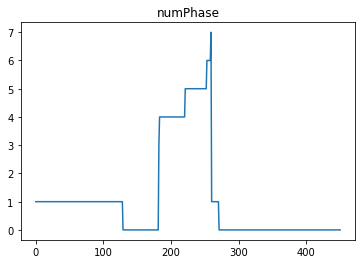

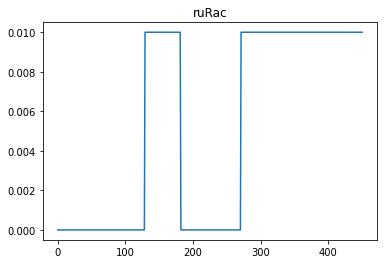

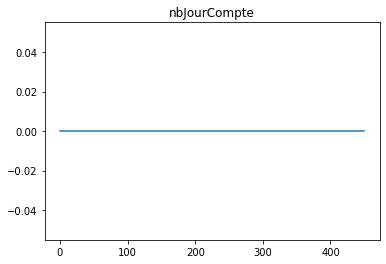

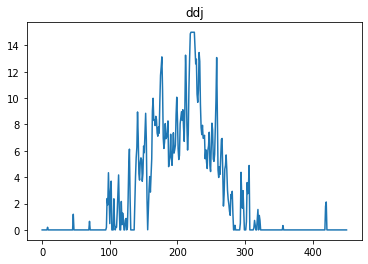

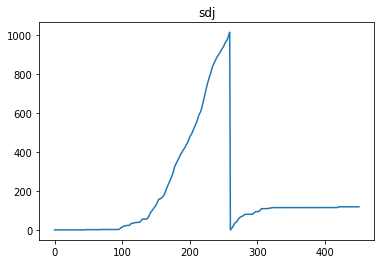

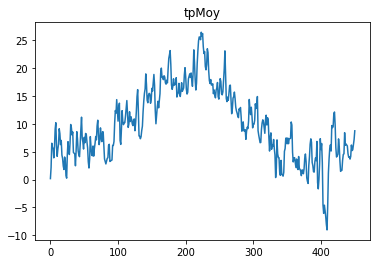

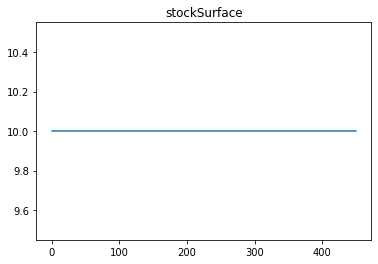

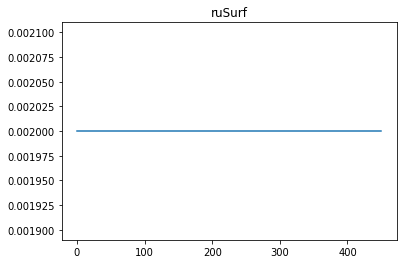

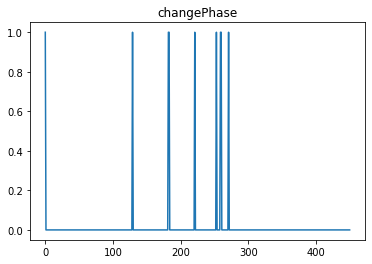

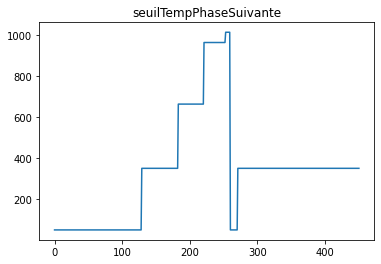

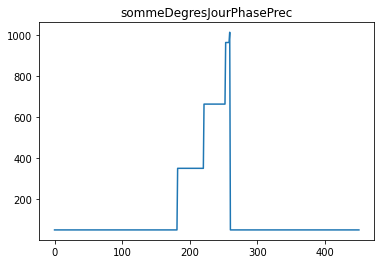

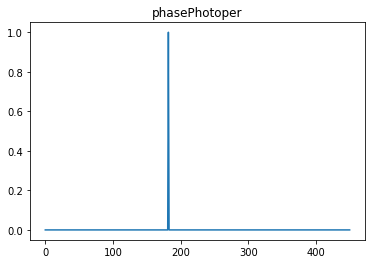

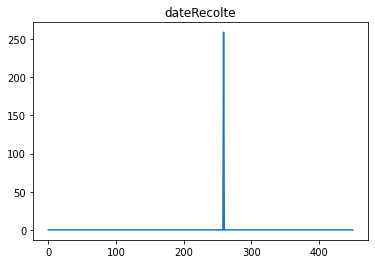

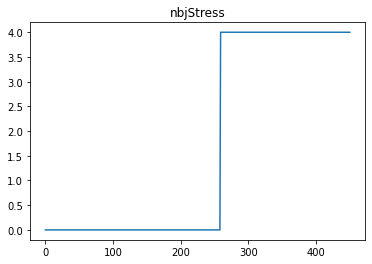

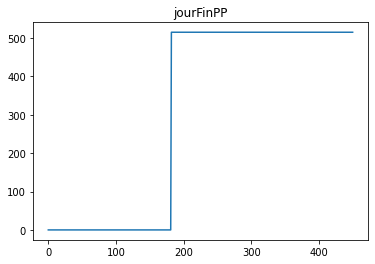

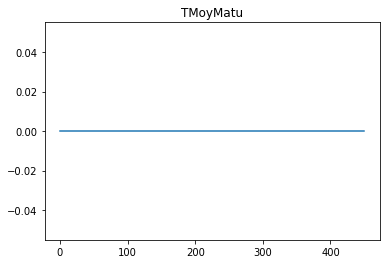

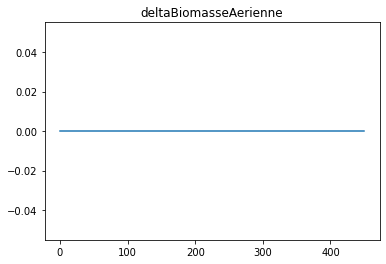

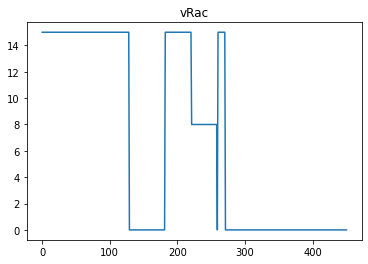

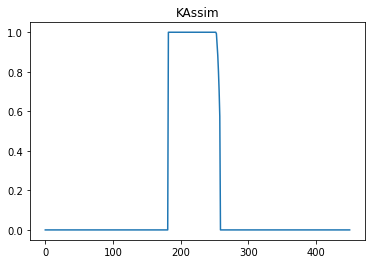

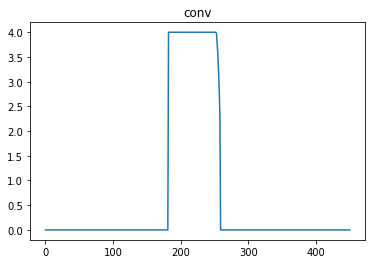

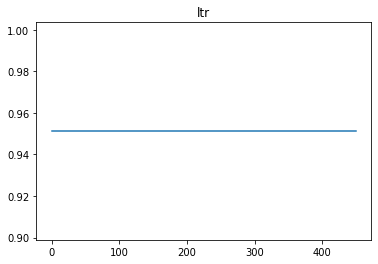

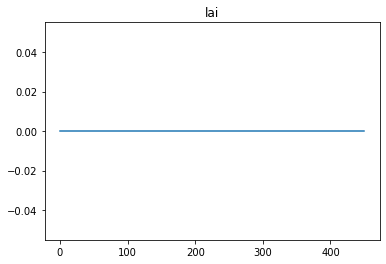

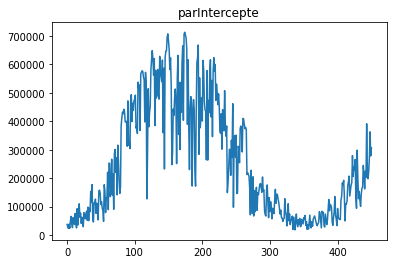

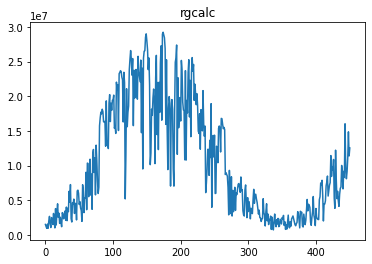

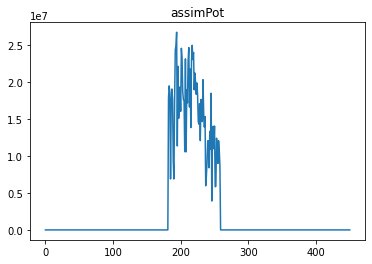

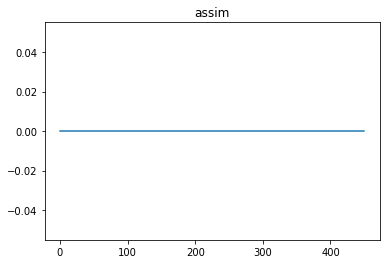

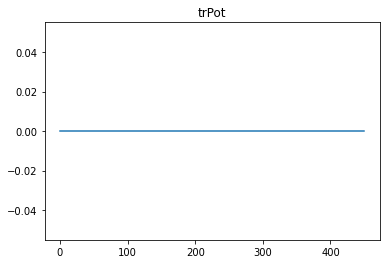

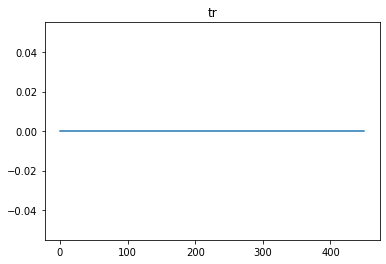

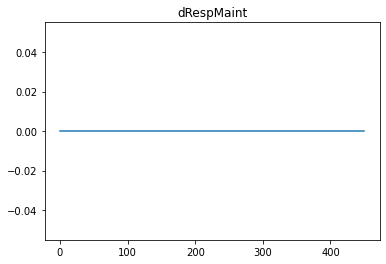

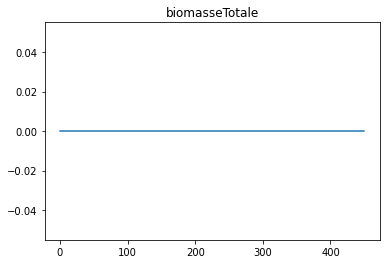

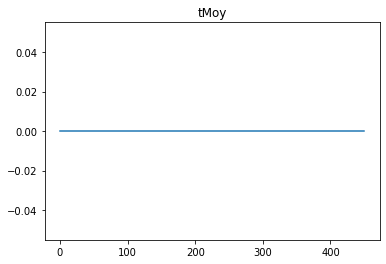

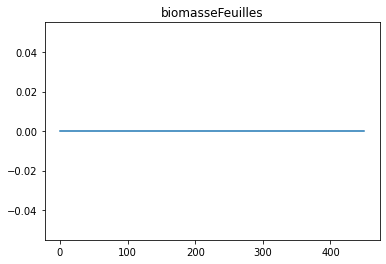

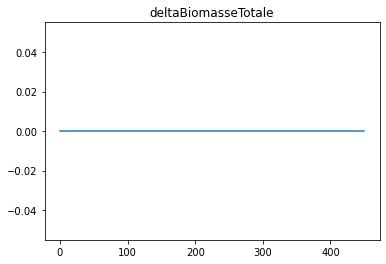

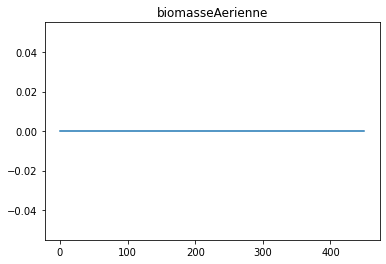

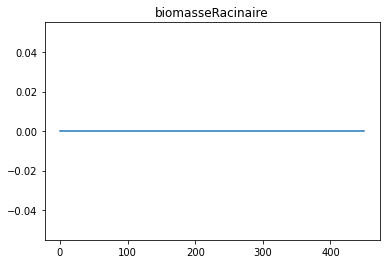

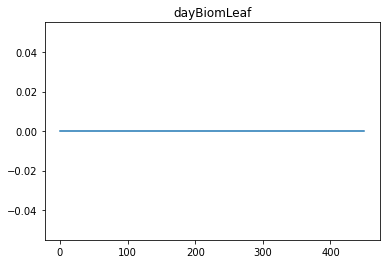

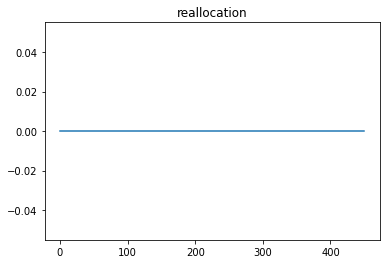

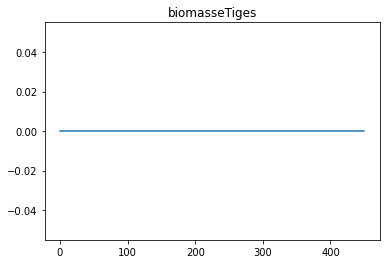

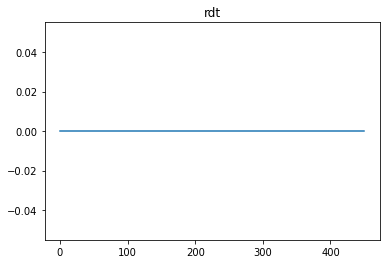

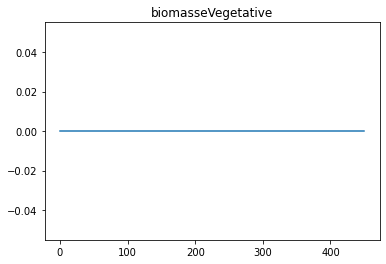

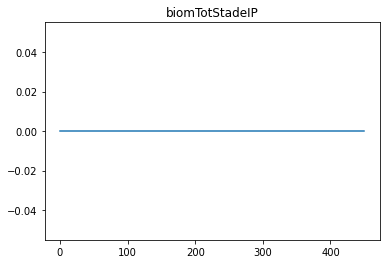

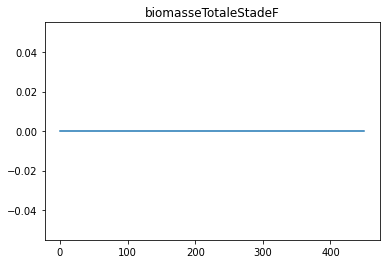

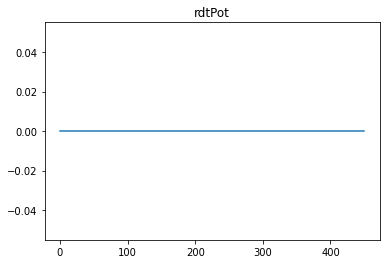

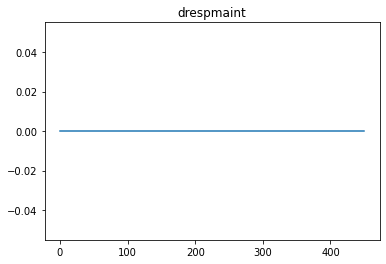

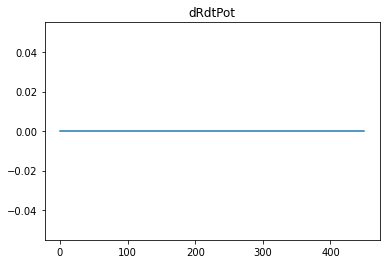

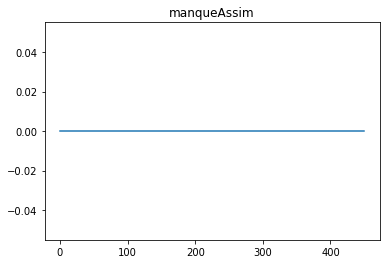

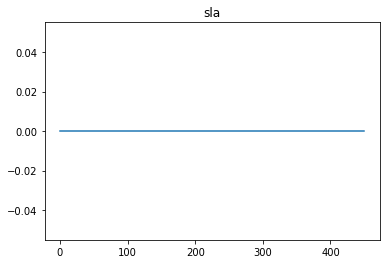

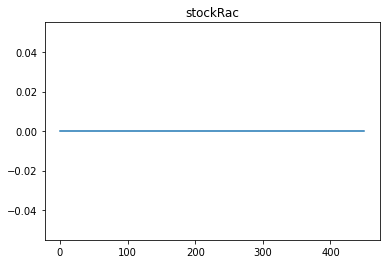

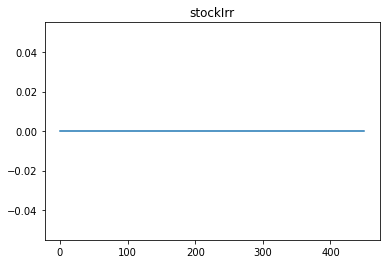

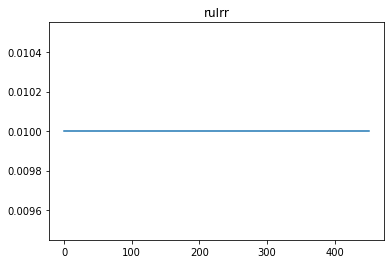

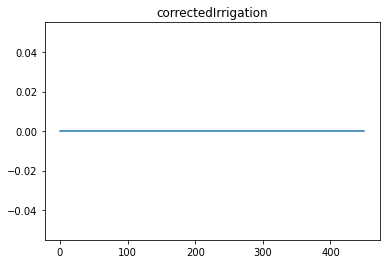

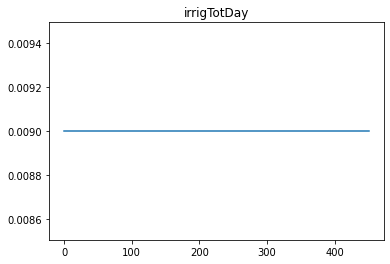

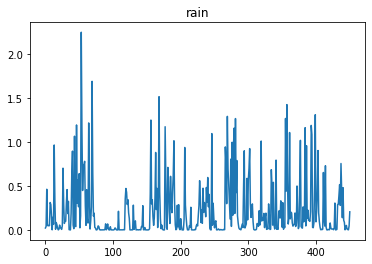

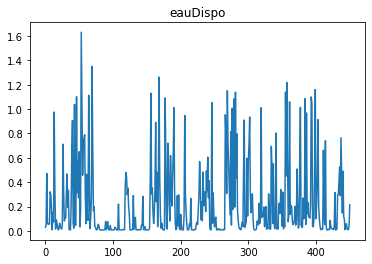

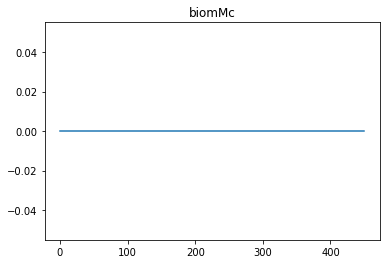

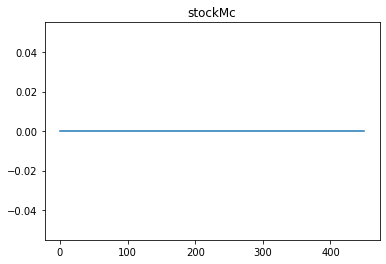

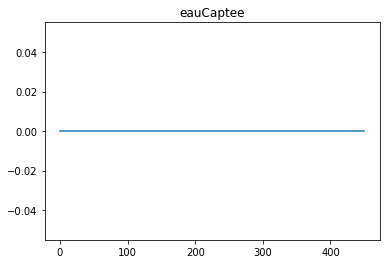

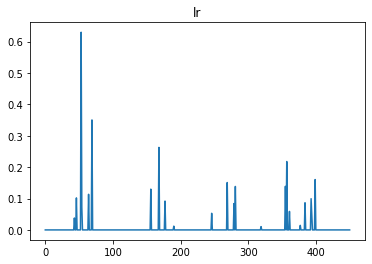

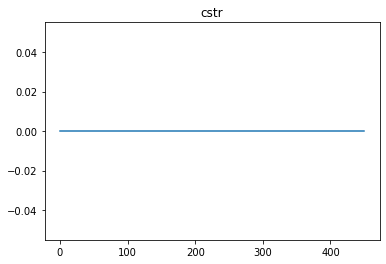

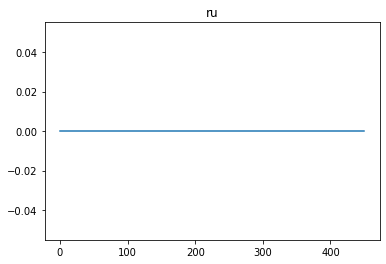

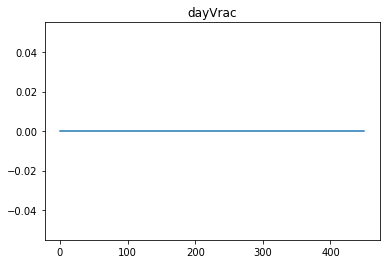

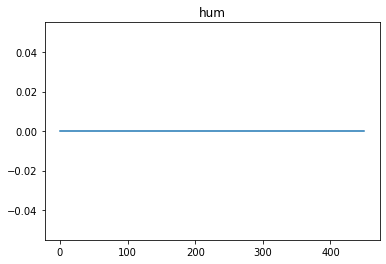

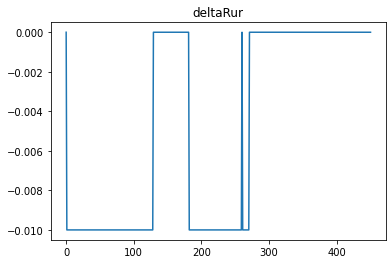

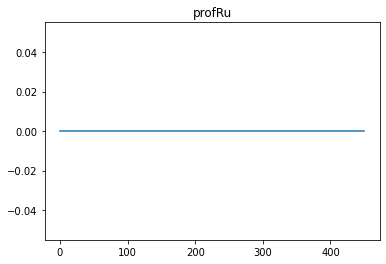

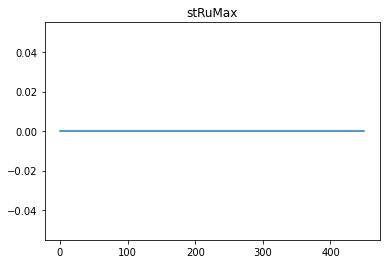

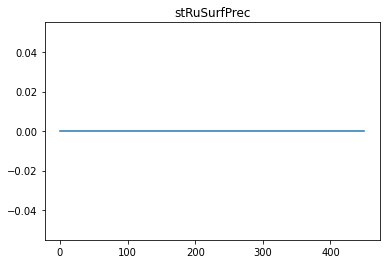

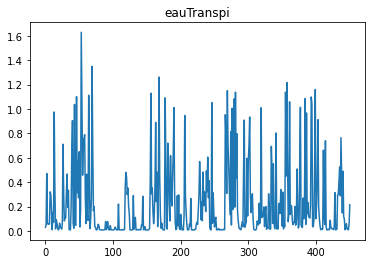

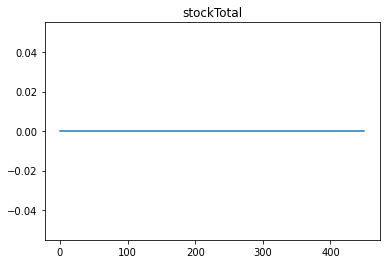

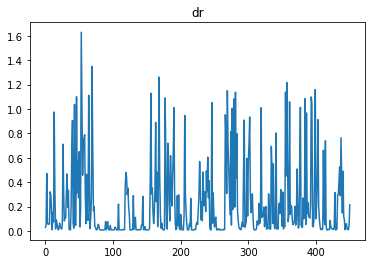

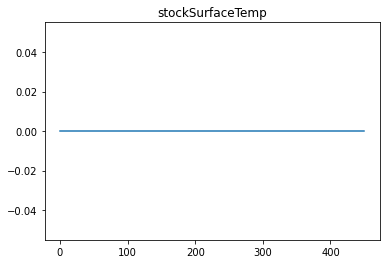

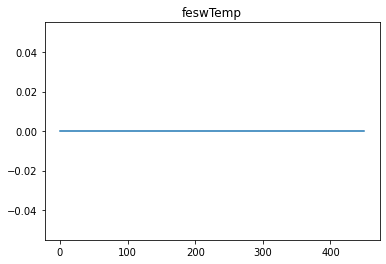

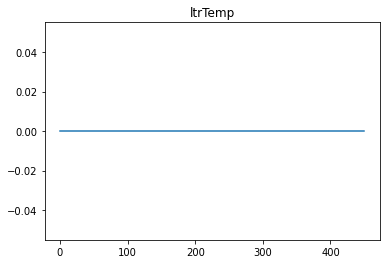

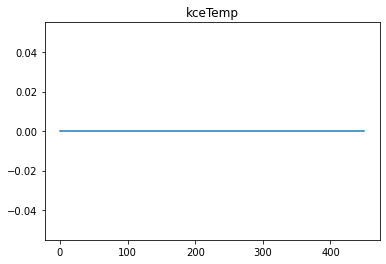

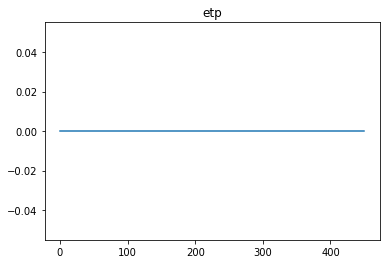

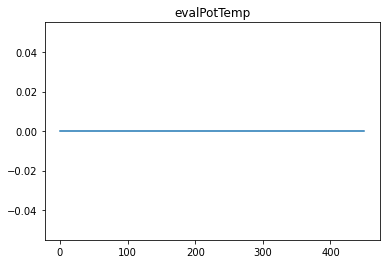

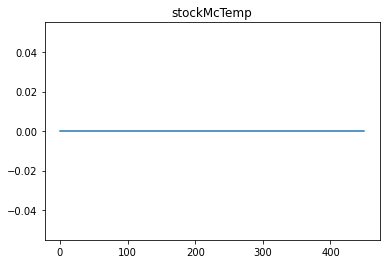

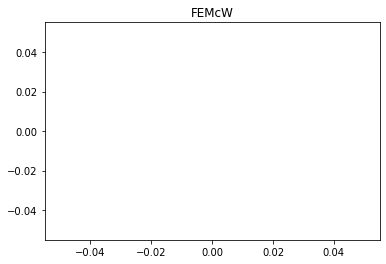

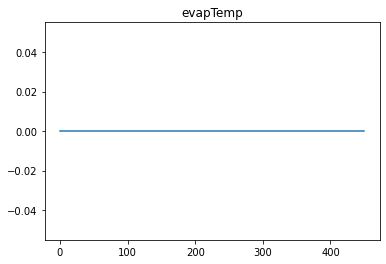

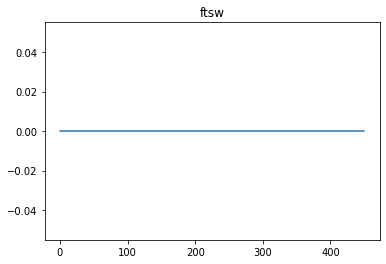

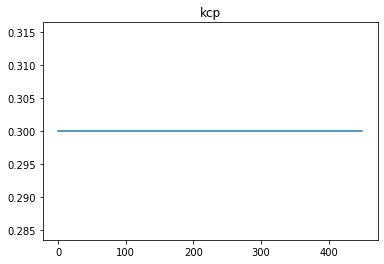

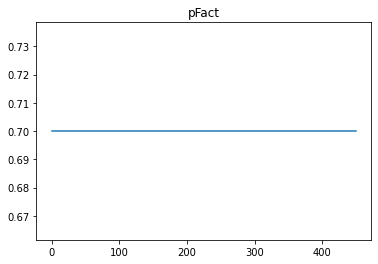

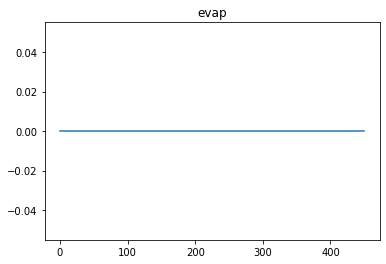

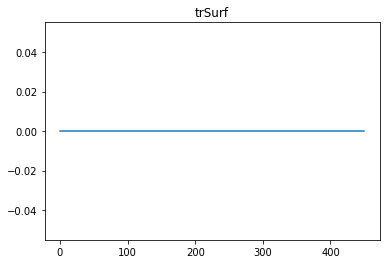

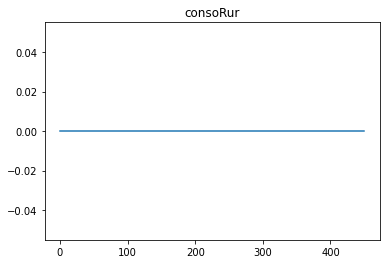

In [173]:
for variable in list(data) :
    plt.plot(data[variable][0,0,:])
    plt.title(variable)
    plt.show()

In [ ]:
xxx

In [ ]:
def bilanHydro(data, paramITK, paramTypeSol, paramVariete):
    data = EvalIrrigPhase(data, paramITK)
    data = rempliMc_evalRunOff(data, paramITK, paramTypeSol)
    data = EvolRurCstr(data, paramITK)
    data = rempliRes(data)
    data = Evaporation(data, paramITK)
    data = Transpiration(data, paramVariete)
    data = ConsoResSep(data)
    return data